# Домашнє завдання

# Частина 2

В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [1]:
# !pip install wandb tensorflow

In [59]:
import os
import math
import random

import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.datasets import imdb
from keras.datasets import fashion_mnist
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from PIL import Image

import wandb
from wandb.keras import WandbMetricsLogger

In [76]:
lr = 0.0000001
n_epochs = 30
batch_size = 32

num_classes = 10

In [77]:
wandb.init(project="Hw10_2", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [78]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [79]:
# Перетворення масивів міток з (100000, 1) на (100000,)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [83]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x_data))

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_x = self.x_data[start_idx:end_idx]
        batch_y = self.y_data[start_idx:end_idx]

        processed_batch_x = [self.preprocess_image(image) for image in batch_x]
        return np.array(processed_batch_x), batch_y

    def preprocess_image(self, image):
        image = Image.fromarray(image)
        image = image.resize((150, 150))
        image = img_to_array(image)
        image = preprocess_input(image)
        return image


In [84]:
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

In [85]:
x_train_rgb = np.stack([x_train] * 3, axis=-1)
x_test_rgb = np.stack([x_test] * 3, axis=-1)

# batch_size = 32
train_generator = DataGenerator(x_train_rgb, y_train_encoded, batch_size)
test_generator = DataGenerator(x_test_rgb, y_test_encoded, batch_size)

In [86]:
# Базова мережа
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Заморожуємо ваги базової моделі
conv_base.trainable = False

# Оголошуємо вхідний тензор для вашої моделі
input_tensor = conv_base.input

# Отримуємо вихідний тензор з базової VGG16 моделі
output_tensor = conv_base.output

# Плоский шар для розгортання в одновимірний вектор
flatten = Flatten()(output_tensor)

# Повнозв'язний шар 1
dense1 = Dense(512, activation='relu')(flatten)

# Повнозв'язний шар 2
# dense2 = Dense(256, activation='relu')(dense1)

# Вихідний шар з 10 нейронами і функцією активації softmax
output_layer = Dense(10, activation='softmax')(dense1)

# Створення моделі
model = Model(inputs=input_tensor, outputs=output_layer)

# Виведення інформації про модель
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [87]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# tf.keras.optimizers.RMSprop(learning_rate=2e-5)
# 'categorical_crossentropy'

In [88]:
callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best_Hw10_2.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [89]:
# history = model.fit(train_generator,
#           y_train_encoded,
#           epochs=n_epochs,
#           batch_size=batch_size,
#           validation_data=(x_test, y_test_encoded),
#           verbose=1,
#           callbacks=[callback_early_stopping, WandbMetricsLogger(), callback_save])


history = model.fit(train_generator,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=test_generator,
                    callbacks=[callback_early_stopping, WandbMetricsLogger(), callback_save])


Epoch 1/30
1875/1875 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.8746

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 200s 106ms/step - loss: 0.5619 - accuracy: 0.8746 - val_loss: 0.3099 - val_accuracy: 0.8937
Epoch 2/30
1875/1875 [==============================] - 201s 107ms/step - loss: 0.2560 - accuracy: 0.9115 - val_loss: 0.2913 - val_accuracy: 0.9020
Epoch 3/30
1875/1875 [==============================] - 201s 107ms/step - loss: 0.2082 - accuracy: 0.9265 - val_loss: 0.3175 - val_accuracy: 0.9030
Epoch 4/30
1875/1875 [==============================] - 201s 107ms/step - loss: 0.1847 - accuracy: 0.9351 - val_loss: 0.3262 - val_accuracy: 0.9024
Epoch 5/30
1875/1875 [==============================] - 201s 107ms/step - loss: 0.1587 - accuracy: 0.9451 - val_loss: 0.3562 - val_accuracy: 0.9088
Epoch 6/30
1875/1875 [==============================] - 202s 107ms/step - loss: 0.1420 - accuracy: 0.9507 - val_loss: 0.3890 - val_accuracy: 0.9003
Epoch 7/30
1875/1875 [==============================] - 202s 107ms/step - loss: 0.1281 - accuracy: 0.9551 - val_loss: 0.392

In [90]:
wandb.finish()

epoch/accuracy,▁▄▆▆▇██
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁
epoch/val_accuracy,▁▅▅▅█▄▆
epoch/val_loss,▂▁▃▃▆██
epoch/accuracy,0.9551
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.12805
epoch/val_accuracy,0.9046


In [92]:
test_loss, test_acc = model.evaluate(test_generator)

313/313 [==============================] - 28s 88ms/step - loss: 0.3922 - accuracy: 0.9046


In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [95]:
predictions = model.predict(test_generator)
predictions[0]

313/313 [==============================] - 26s 83ms/step


array([7.9896883e-22, 2.1406115e-25, 1.0838628e-31, 1.9511827e-19,
       3.9688767e-29, 6.5107342e-09, 1.0492220e-24, 2.5770044e-07,
       1.0257207e-20, 9.9999976e-01], dtype=float32)

In [96]:
predictions.shape

(10000, 10)

In [97]:
np.argmax(predictions[1])

2

In [98]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names[2]

'Pullover'

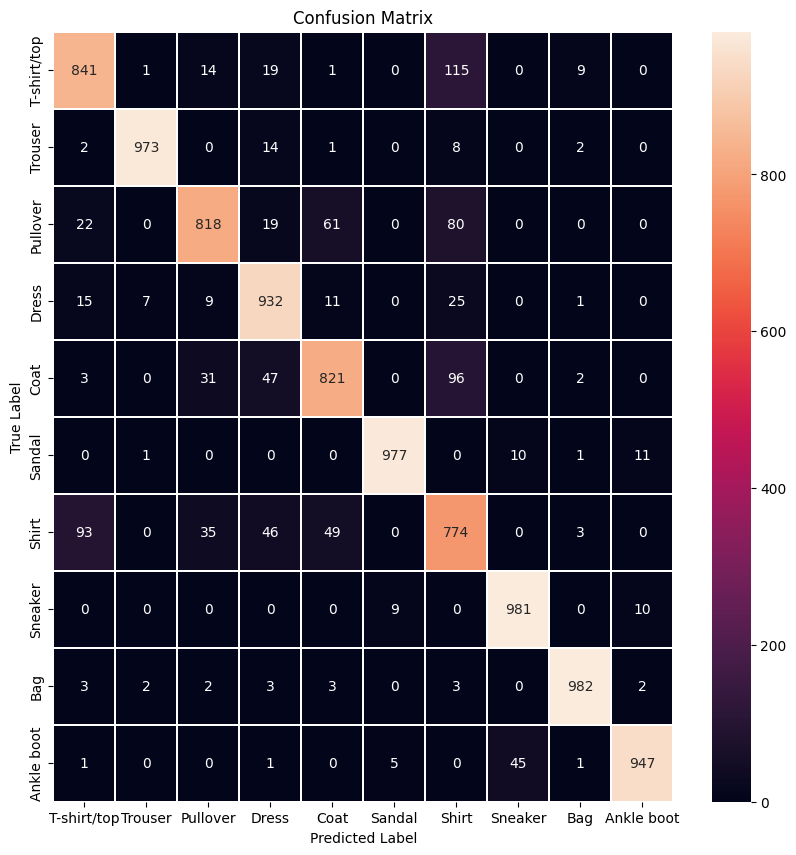

In [99]:
y_pred_classes = np.argmax(predictions, axis = 1)
y_test = y_test.reshape(-1,1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
plt.show()

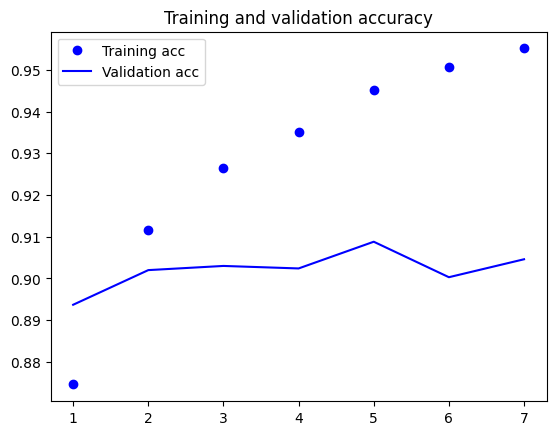

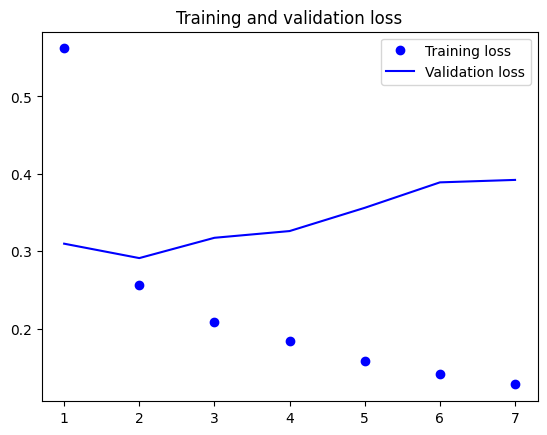

In [91]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

# Висновок

## Завдання 1
    *   Згорткові шари покращили точність val_accuracy з 0.88 на 0.92. Але модель є перенавченою, по тестам з різними метриками я досяг меншого перенавчання, але воно всеодно було присутнім.
    *   Згорткові шари покращують навчання мережі. Для того щоб боротись з перенавчанням потрібно збільшити датасет як варіант додати трансформацій для зображень.

## Завдання 2
    *   Використання базової моделі VGG16 показало гыршы результати за звичайну згорткову модель. Модель є перенавченою, потрібно збільшувати датасет, вводити додаткові трансформації.

